## Download Japanese Fonts for Visualization

In [2]:
!curl -L 'https://moji.or.jp/wp-content/ipafont/IPAexfont/ipaexg00401.zip' -o ../data/ipaexg00401.zip
!unzip ../data/ipaexg00401.zip -d ../data/ && rm ../data/ipaexg00401.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4068k  100 4068k    0     0  3559k      0  0:00:01  0:00:01 --:--:-- 3559k
Archive:  ../data/ipaexg00401.zip
   creating: ../data/ipaexg00401/
  inflating: ../data/ipaexg00401/ipaexg.ttf  
  inflating: ../data/ipaexg00401/IPA_Font_License_Agreement_v1.0.txt  
  inflating: ../data/ipaexg00401/Readme_ipaexg00401.txt  


## Import Libraries

In [3]:
import re
import MeCab
import warnings
import mojimoji
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
import plotly.graph_objs as go
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from umap import UMAP
from tqdm.notebook import tqdm
import torch
from transformers import BertJapaneseTokenizer, BertModel

warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 10000)

In [4]:
class Cfg:
    seed = 42
    model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
    max_length = 512 
    category = ['dokujo-tsushin', 
                'it-life-hack', 
                'kaden-channel', 
                'livedoor-homme', 
                'movie-enter',
                'peachy',
                'smax',
                'sports-watch',
                'topic-news']
    extract_feats = ['名詞', '形容詞']
    font_path = '../data/ipaexg00401/ipaexg.ttf'
    stopwords_libpath = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'

In [5]:
data = pd.read_csv('../data/headlines_generation_corpus/livedoornews.csv')

## EDA

In [6]:
data.sample(3, random_state=Cfg.seed)

,url,datetime,title,body,media
6473,http://news.livedoor.com/article/detail/6894879/,2012-08-28T07:55:00+0900,全国のねこカフェをチェックできる「ねこカフェ行くにゃ？全国版」【Androidアプリ】,ねこカフェ行きたいにゃー\nかわいい猫を眺めたりもふもふしたりして癒される「猫カフェ」。どこにいても思い立ったらすぐに行きたーい！\nそんな時には今回紹介するAndroidアプリ「ねこカフェ行くにゃ？全国版」がおすすめです。全国にある猫カフェ141店舗を収録したアプリです。\nさっそくアプリでねこカフェを検索してみましょう。\n起動時に表示される黒猫の後ろ姿がキュートです。\n各地方ごとに分かれているので、任意の地方をタップします。\n地方を選べば猫カフェの一覧が出てきますので、気になるお店をタップしてみます。\nお店の営業時間や定休日などの情報は店舗のサイトより取得しているとのことで、シンプルにまとめられています。\n住所をタップすることで地図かナビゲーションを起動したり、電話番号のタップで電話を掛けることもできて便利です。\nURLをタップすれば店舗サイトを見ることもできますし、画面中央部の［Twitterでつぶやく］ボタンからTwitterへの投稿をすることもできます。\n写真を付けて投稿もできますので、撮影可能なら猫の写真を付けても良いですよね。\n。\nつぶやいた後はほんわかしたイラストが表示されますにゃん。\nぜひこのアプリで猫カフェを探して、充実した休日を過ごしてくださいね！\n記事執筆：Hisumi\nアプリ名：ねこカフェ行くにゃ？全国版\n価格：無料\nカテゴリ：アプリ ＞ ライフスタイル\n開発者：luciesteel\nバージョン：1.3.5\nANDROID 要件：2.1 以上\nGoogle Play Store：http://play.google.com/store/apps/details?id=nekocafez.com\n■関連リンク\n・エスマックス（S-MAX）\n・エスマックス（S-MAX） smaxjp on Twitter\n・S-MAX - Facebookページ,smax
1921,http://news.livedoor.com/article/detail/6647198/,2012-06-11T17:00:00+0900,ディズニーの総力を結集した夢の映像プロジェクトがパッケージ化,今年4月に劇場公開された、悲劇のヒーロー“ジョン・カーター”の全宇宙の存亡を懸けた壮絶な闘いを描くアクション・スペクタクル巨編『ジョン・カーター』。早くも8月22日には同作がブルーレイ、DVD＋ブルーレイセット、3Dスーパー・セットとして発売。3D＆2DブルーレイとDVDのレンタル、オン・デマンド配信も同日より開始される。\n『ジョン・カーター』は、「スター・ウォーズ」や「アバター」に多大なインスピレーションを与えたと言われる伝説的SF小説「火星のプリンセス」を原作に、ディズニー／ピクサー作品『ファインディング・ニモ』『ウォーリー』で世界を沸かせたアンドリュー・スタントン監督が初の実写映画に挑戦。滅亡の危機に瀕した神秘の惑星“バルスーム”を舞台に、愛する家族を失った地球の男の驚異の戦いが描かれる。\nスタントン監督のイマジネーションを元に、世界を牽引するトップクリエイターたちによって、様々なクリ—チャー達や、巨大な要塞、優雅な飛行艇など、誰も見たことのない“バルスーム”が創造され、驚異の世界が誕生。今から100年も昔に未知なる惑星に想いを馳せ、SF史上に燦然と輝く伝説となった斬新な原作を、ディズニーが完全映画化。壮大なスケールと手に汗握る冒険、ディズニーの総力を結集した夢の映像プロジェクトが自宅で楽しめる。\n・『ジョン・カーター』特集ページ,movie-enter
5090,http://news.livedoor.com/article/detail/6093748/,2011-12-14T10:00:00+0900,がんばる女子はどんな音楽の聞き方をしている？,今年は、女子サッカーワールドカップでの「なでしこジャパン」優勝や、バレーボール世界選手権での女子日本代表のメダル獲得など、がんばる女子の活躍が目立ちました。ただ昔と違うのは、みなさんが本業だけじゃなく恋愛やオシャレにも頑張っている点。\nもちろん、私達の身の回りにも仕事や勉強や恋にがんばる女子たちはたくさんいます。中には音楽を聞くことで自分のモチベーションを上手くコントロールしている方も意外と多いもの。そこで、今回Peachy編集部ではそんな、がんばるイマドキ女子たちは、どんな音楽の聞き方をしているのかを調査してきました!\nCASE1：金子智美\n年齢：26歳\n職業：IT企業の広報を担当\nイヤホンカラー：お気に入りはピンクとホワイト\n自社イベントにも積極的に参加する等、IT業界の広報として多忙な日々を送っている。\nQ：金子さんの「モチベーションを高めたい時」ってどんな時ですか?\nA：やはり、自社イベントで司会を担当する時ですね。あ、もちろん毎日の業務の中でも勝負所はありますので、それなりにモチベーションを高めてから会社に行くようにしています!\nQ：そういう自社イベントや毎日の仕事の中で、モチベーションを上げる工夫ってされていますか?\nA：力強い女性ボーカルの洋楽を聞くとヤル気がでてきます!ですから、音楽を聴くのは通勤電車の中とオフィスがメインですね。ただボリュームが大きくなりがちなので、後になって「音漏れしてなかったかな」って反省することもありました。\n音漏れがほとんど気になりません!Q：音漏れの対策ですと、今使っていただいているイヤホン、パナソニックのHJE255はいかがですか?\nA：耳の奥までグッと入ってフィット感がありますね。音漏れも気にならないので、このイヤホンなら、シーンを気にせず音楽を聴いてモチベーションUPできちゃうので、仕事もはかどります!\nCASE2：加藤絢香\n年齢：20歳\n職業：大学生\nイヤホンカラー：お気に入りはピンクとブルー\n勉強はもちろん最近はメディアでの活躍も始めている。\nQ：加藤さんの「モチベーションを高めたい時」ってどんな時ですか?\nA：そうですね、学校の試験やデートのある日は気合が入れるようにしています。\nQ：確かに試験の日はテンションが下がりますよね。でもモチベーションは上げないといけない…難しい日ですね。そんな時、やる気のコントロールなんてどうされているんですか?\nA：う〜ん、私は朝コラーゲンドリンクを飲むと気合が入るというジンクスがあるんですけど、それと一緒にJUJUとか木村カエラさんの曲を聞くと…相乗効果っていうんですか、「がんばろう!」って気合がどんどん湧いてくるんです!\nカラーバリエーションは10種類Q：分かります!音楽ってモチベーションを上げてくれますよね!そうなってくると、音楽を聞くイヤホンも重要になってきますが、今回お試しいただいているパナソニックのHJE255はいかがですか?\nA：小さくて耳にフィットして使いやすいですね!音漏れが気にならないので試験前の教室でもどんどん気合を上げられます。色も10種類のバリエーションがあって、気分で使い分けられそうでいいな!と思いました。\nCASE3：小澤英恵\n年齢：31歳\n職業：舞台女優\nイヤホンカラー：お気に入りはブルーとグリーン\n舞台女優として忙しい日々を送っている。\nQ：小澤さんの「モチベーションを高めたい時」ってどんな時ですか?\nA：そうですね、やはりドラマ撮影や舞台の本番中はまさに勝負だと思っています。\nQ：例えばですが、モチベーションを上げ過ぎて緊張する、なんてことはありませんか?\nA：舞台で大事なのは集中力ですから、心身ともにリラックスできるように心がけています。勝負の日が近づくとクラシックやヒーリングミュージックなどを聞いています。上手くリラックスができれば、集中力も高まりますから。\n新デザインのイヤーピースで耳にフィット!Q：なるほど…特にイヤホンを使用する場合って、集中力を高めるのにつけ心地がきになりませんか?\nA：もちろん!上手く耳にはまらないと、それだけで集中が途切れますから。このイヤホンなら、耳にピタっとはまって、全部の音が耳の中に入ってくるように感じます。これなら普段以上に集中力を高められます!\nCASE4：丸山莉奈\n年齢：19歳\n職業：大学生\nイヤホンカラー：お気に入りはパープルとピンク\n勉強だけでなく、最近はメイクやファッションに興味も。\nQ：丸山さんの「モチベーションを高めたい時」ってどんな時ですか?\nA：学校で気になる人と授業が一緒になる日は、いつも以上に気持ちを上げて学校へ行きます!\nQ：それはテンションが上がりますね。\nA：はい!でも自分だけゴキゲンだと相手が引いてしまうので、何て言うんでしょう…テンションを調整するために通学途中で音楽を聴きますね。ジャンルはバラバラで洋楽にR&B…あ、後J-POPも聴きますよ。ただ電車内だと音漏れが気になっちゃうんですよね。自分の聞いている音楽が周りの人にバレちゃうのって恥ずかしいじゃないですか?\nアジャストホルダーでコードが絡まるのを防止Q：確かにそうですね。今使っているイヤホンHJE255ですが、使い

In [7]:
print(f'titleカラムの文字数統計量 \n {data.title.apply(lambda x: len(x)).describe()}\n')
print(f'bodyカラムの文字数統計量 \n {data.body.apply(lambda x: len(x)).describe()}')

titleカラムの文字数統計量 
 count    7367.000000
mean       37.673001
std        14.800572
min         6.000000
25%        28.000000
50%        36.000000
75%        45.000000
max       142.000000
Name: title, dtype: float64

bodyカラムの文字数統計量 
 count     7367.000000
mean      1205.801004
std        748.930301
min         11.000000
25%        687.000000
50%       1011.000000
75%       1552.000000
max      11826.000000
Name: body, dtype: float64


In [8]:
class CustomMeCabTagger(MeCab.Tagger):
    def __init__(self, extract_feats=None):
        super().__init__()
        self.extract_feats = extract_feats

    def parse_to_series(self, series):
        results = []
        texts = ' '.join(series.tolist())
        for sentence in texts.split('。'):
            parsed = self.parse(sentence)
            for line in parsed.split('\n'):
                try:
                    text, feature = line.split('\t')
                except ValueError:
                    pass
                feature = [None if f == '*' else f for f in feature.split(',')][0]
                if isinstance(self.extract_feats, list):
                    if feature in self.extract_feats:
                        results.append(text)
                else:
                    results.append(text)
        return pd.Series(results, name=series.name)

    def parse_to_string(self, series):
        results = []
        texts = ' '.join(series.tolist())
        for sentence in texts.split('。'):
            parsed = self.parse(sentence)
            for line in parsed.split('\n'):
                try:
                    text, feature = line.split('\t')
                except ValueError:
                    pass
                feature = [None if f == '*' else f for f in feature.split(',')][0]
                if isinstance(self.extract_feats, list):
                    if feature in self.extract_feats:
                        results.append(text)
                else:
                    results.append(text)
        return ' '.join(results)


class Ja_StopWords(object):
    def __init__(self, libpath):
        self.libpath = libpath

    def apply_stopwords_series(self, series):
        libfile = urllib.request.urlopen(self.libpath)
        lib_stopwords = [line.decode('utf-8').strip() for line in libfile]
        lib_stopwords = [stopwords for stopwords in lib_stopwords if not stopwords == u'']
        lib_stopwords = list(set(lib_stopwords))        
        series = pd.Series(
            [value for value in series if value not in lib_stopwords if not value.isdigit()], 
            name=series.name
            )
        return series    

    def apply_stopwords_string(self, text):
        libfile = urllib.request.urlopen(self.libpath)
        lib_stopwords = [line.decode('utf-8').strip() for line in libfile]
        lib_stopwords = [stopwords for stopwords in lib_stopwords if not stopwords == u'']
        lib_stopwords = list(set(lib_stopwords))        
        text = ' '.join([word for word in text.split(' ') if word not in lib_stopwords if not word.isdigit()])
        return text

In [9]:
tagger = CustomMeCabTagger(Cfg.extract_feats)
stopwords = Ja_StopWords(Cfg.stopwords_libpath)

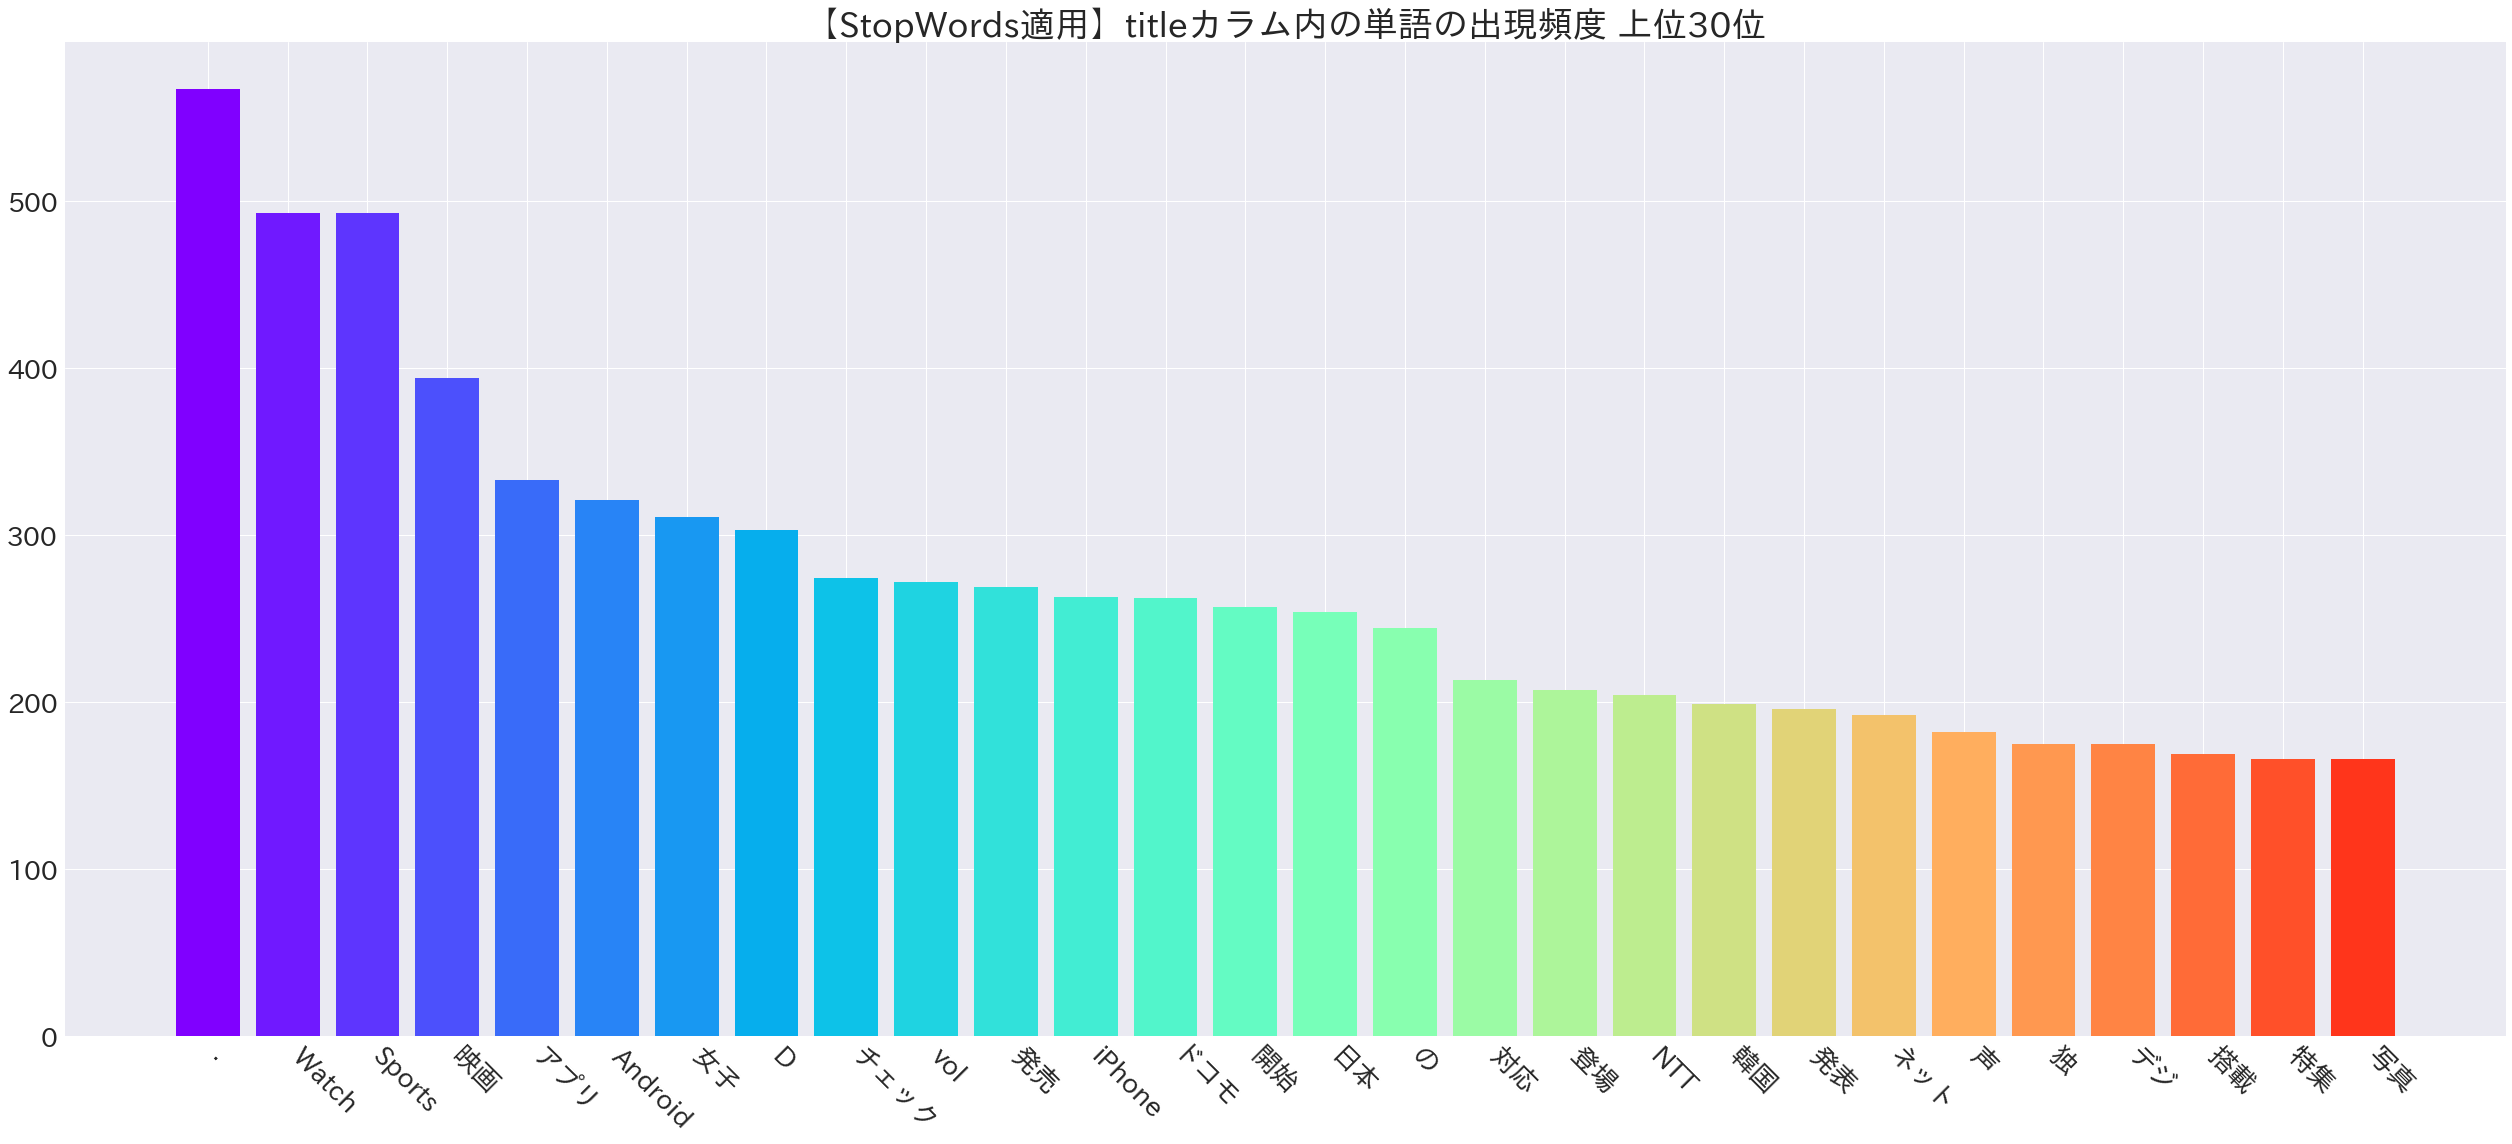

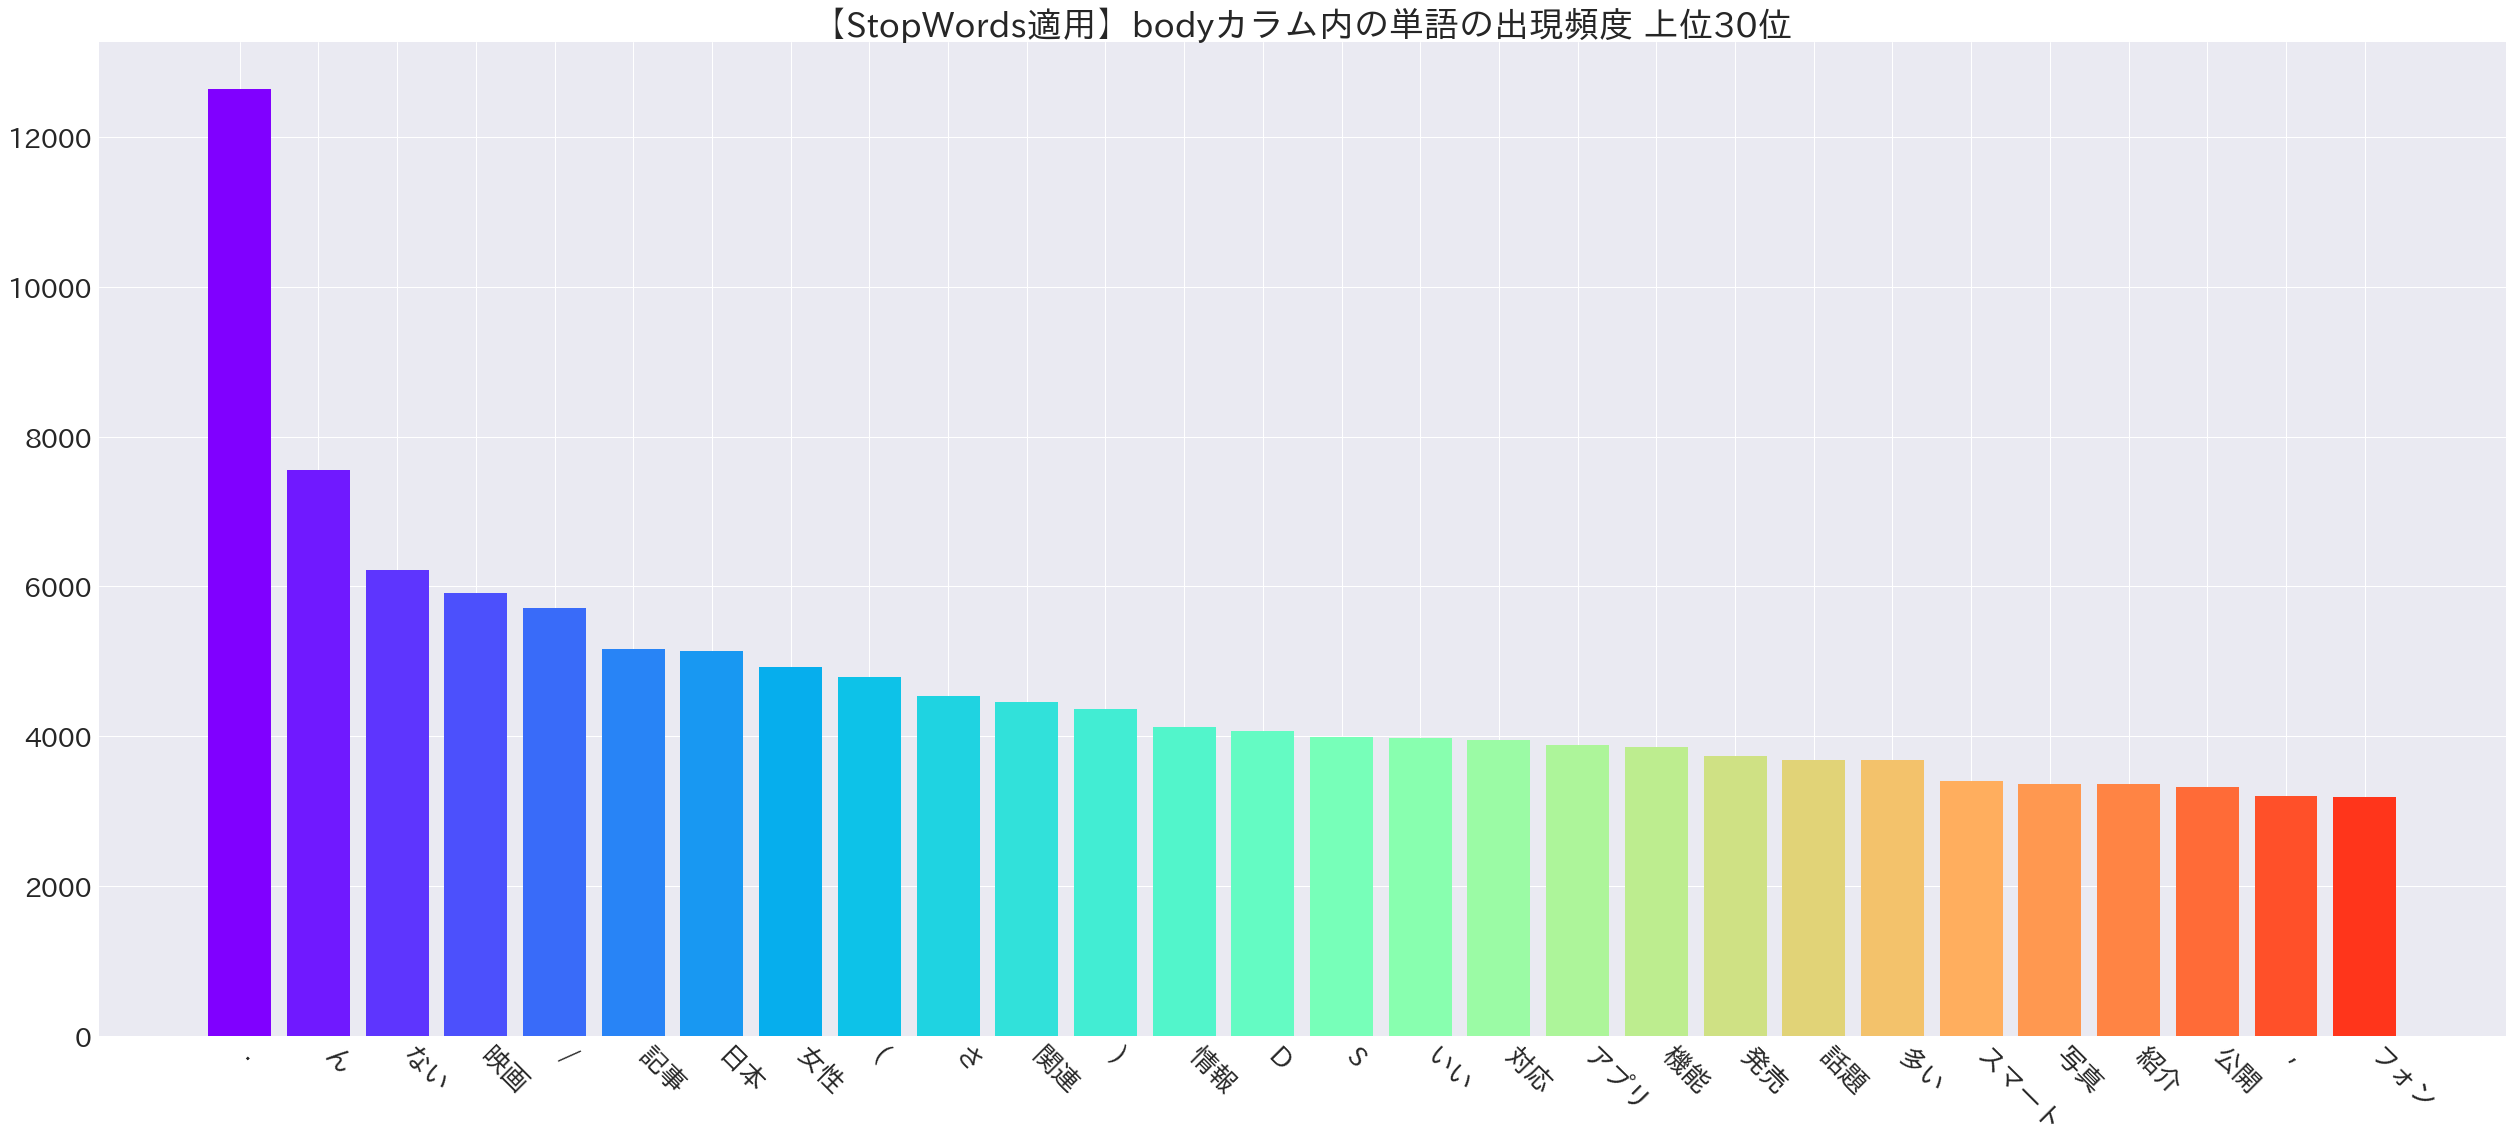

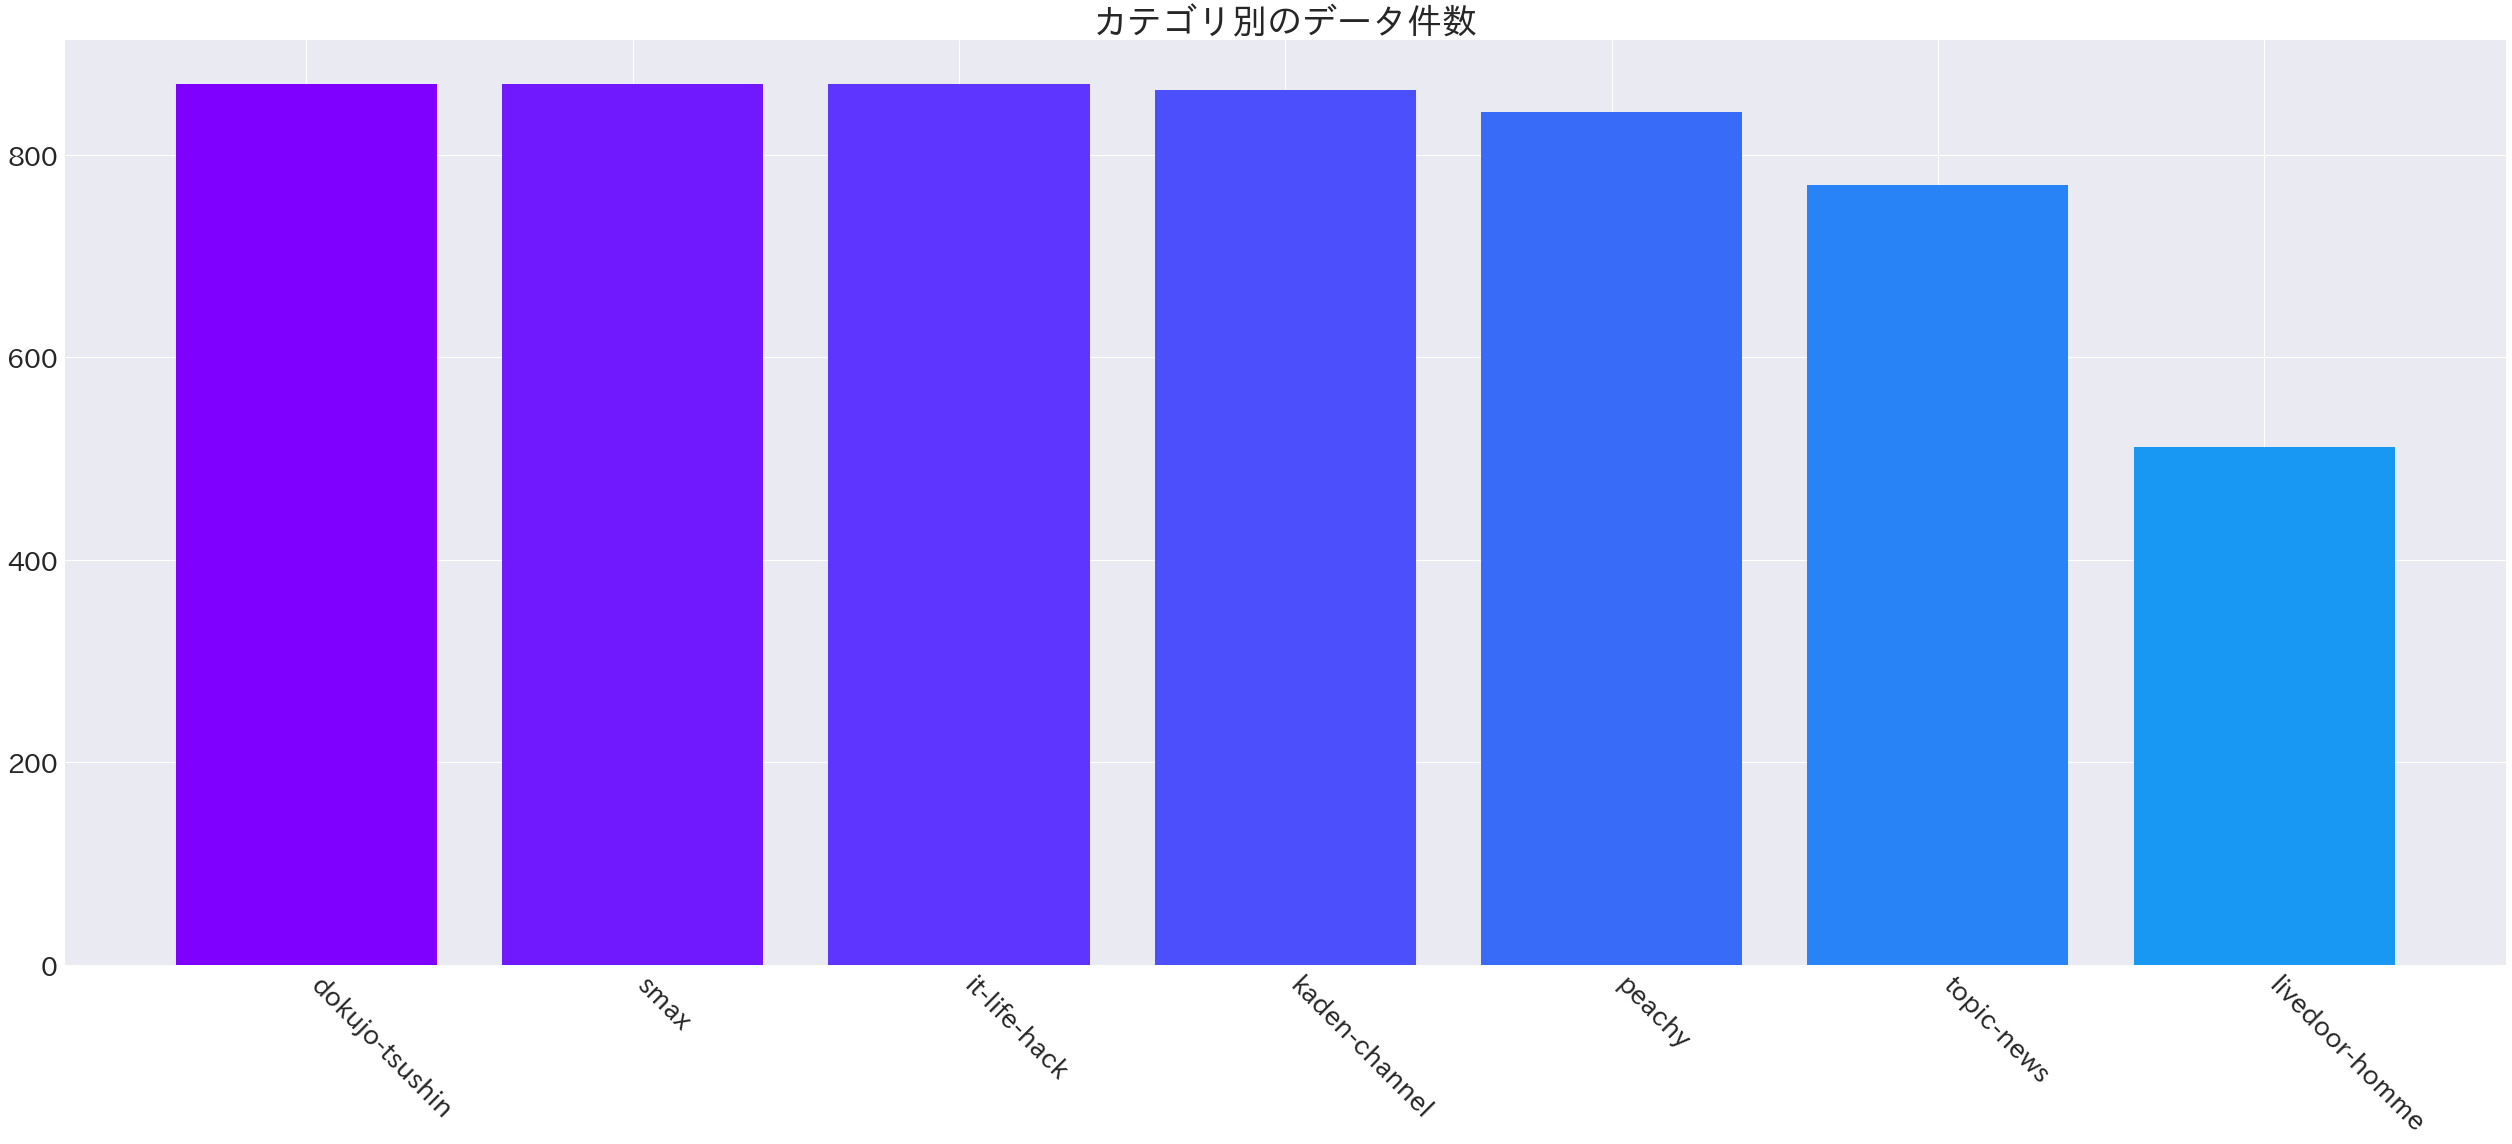

In [10]:
# # plotly version
# def bar_plot(word_counts, title): 
#     data = [go.Bar(
#                 x = word_counts.index.values[2:30],
#                 y = word_counts.values[2:30],
#                 marker= dict(colorscale='Jet',
#                             color=word_counts.values[2:100]),
#                 text='Word counts'
#         )]
#     layout = go.Layout(title=title)
#     fig = go.Figure(data=data, layout=layout)
#     fig.show()

def bar_plot(word_counts, title):
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    fig = plt.figure(figsize=(35,16))
    bar_colors = cm.rainbow(np.linspace(0,1,30))
    plt.bar(word_counts.index.values[2:30], word_counts.values[2:30], color=bar_colors, linewidth=0)
    plt.tick_params(labelsize=27)
    plt.xticks(rotation=-45, ha='left')
    plt.title(title, fontsize=35) 
    plt.tight_layout()

bar_plot(stopwords.apply_stopwords_series(tagger.parse_to_series(data.title)).value_counts(), '【StopWords適用】titleカラム内の単語の出現頻度 上位30位')
bar_plot(stopwords.apply_stopwords_series(tagger.parse_to_series(data.body)).value_counts(), '【StopWords適用】bodyカラム内の単語の出現頻度 上位30位')
bar_plot(data.media.value_counts(), 'カテゴリ別のデータ件数')

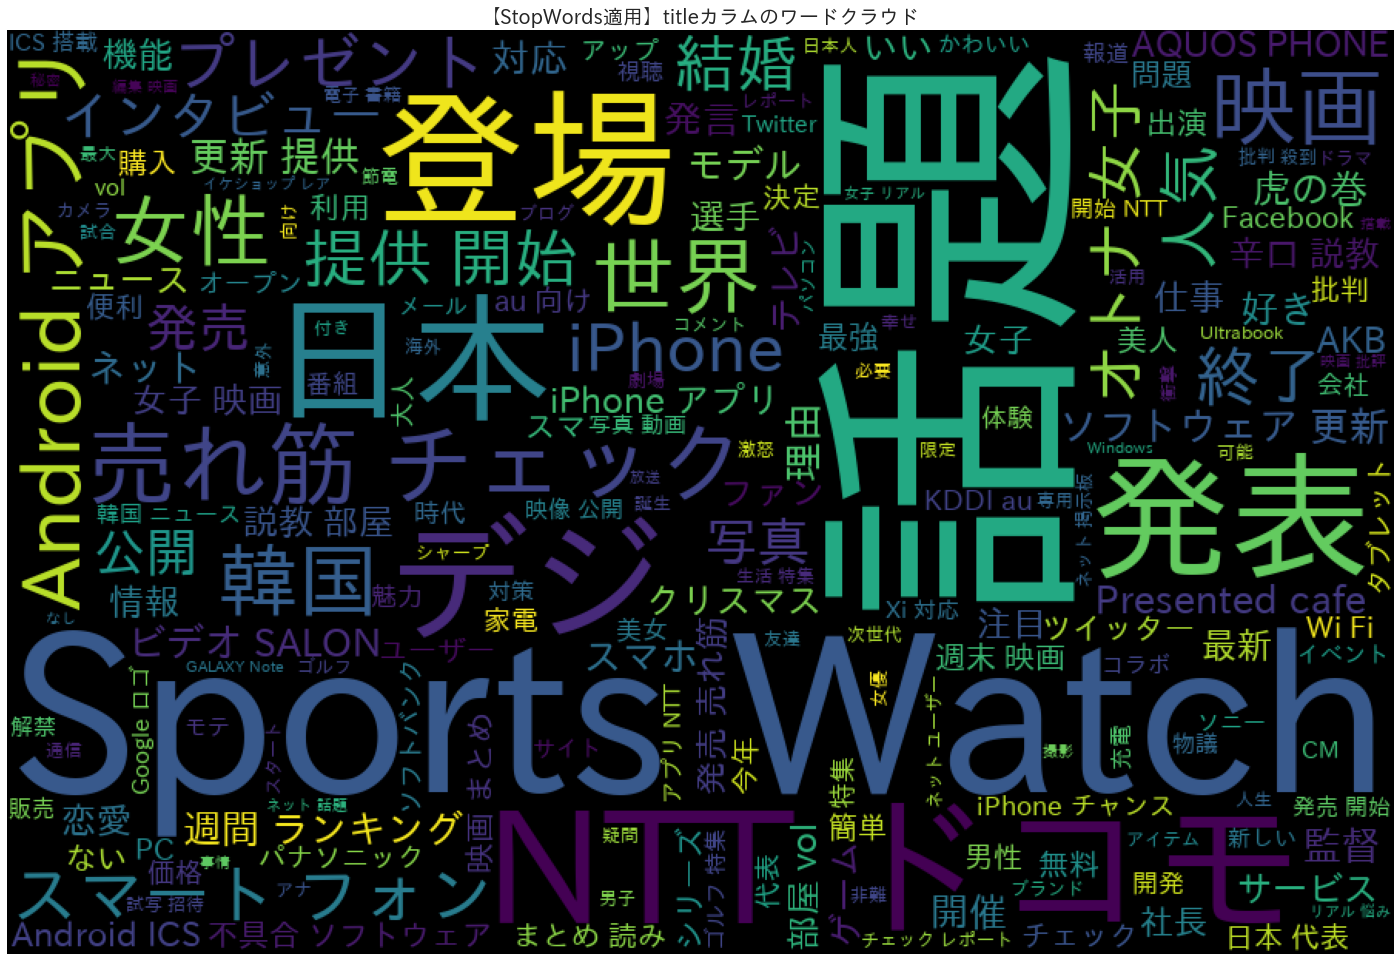

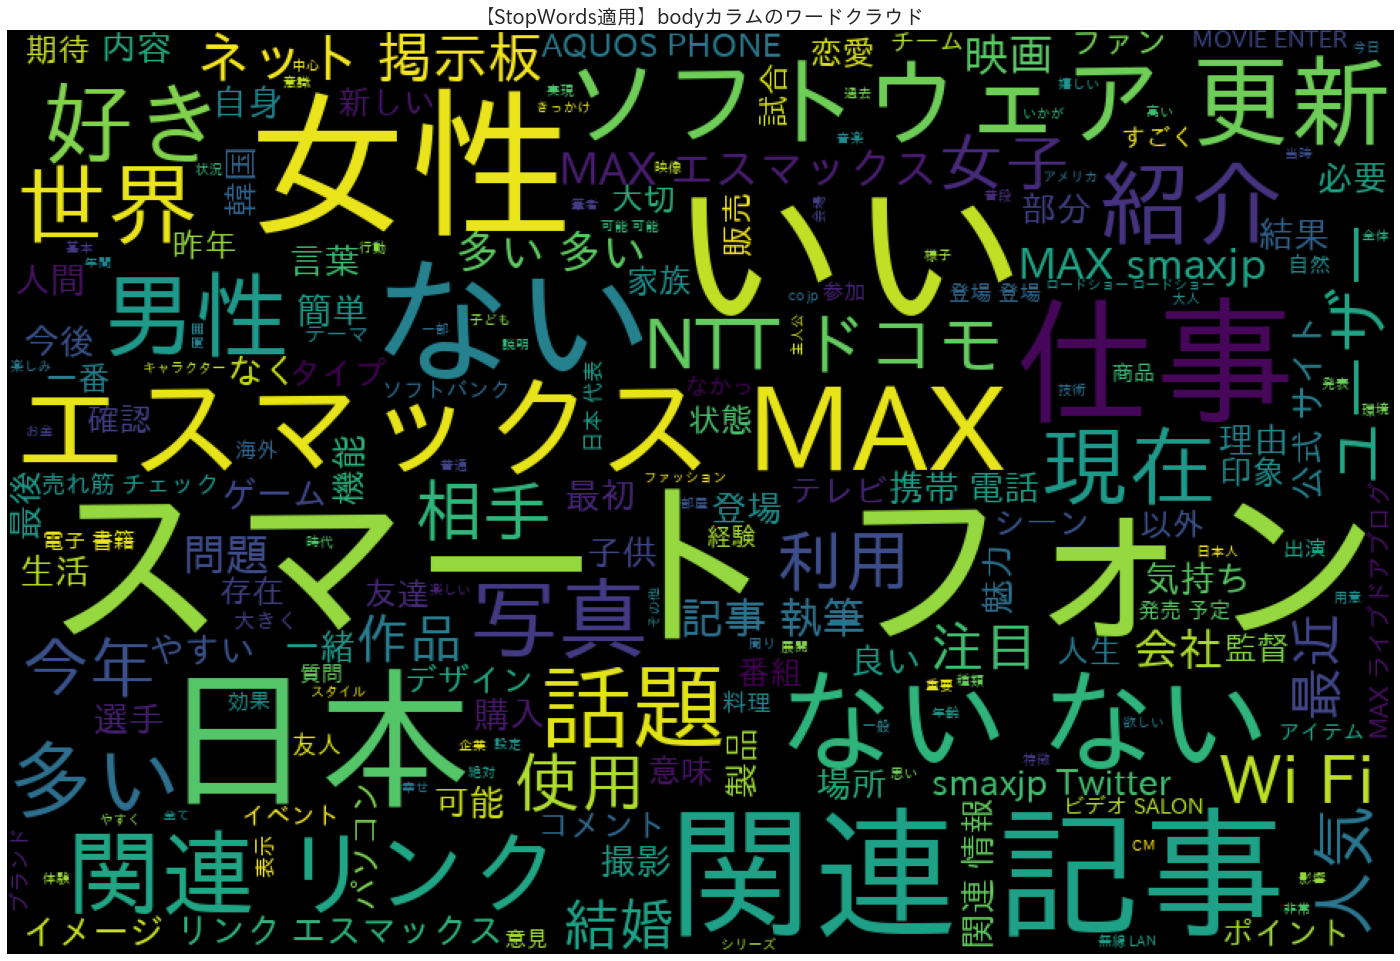

In [11]:
def word_cloud(series, title):
    japanize_matplotlib.japanize()
    wc = WordCloud(width=900, height=600, font_path=Cfg.font_path) 
    tagger = CustomMeCabTagger(Cfg.extract_feats)
    stopwords = Ja_StopWords(Cfg.stopwords_libpath)
    wc.generate(stopwords.apply_stopwords_string(tagger.parse_to_string(series)))
    plt.figure(figsize=(25,17))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontdict={'fontsize': 20})

word_cloud(data.title, '【StopWords適用】titleカラムのワードクラウド')
word_cloud(data.body, '【StopWords適用】bodyカラムのワードクラウド')

## Sentence vectorization

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertJapaneseTokenizer.from_pretrained(Cfg.model_name)
model = BertModel.from_pretrained(Cfg.model_name)
model = model.to(device)

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
le = LabelEncoder()
labels = le.fit_transform(data['media'].values)
vecs = []

for text_body in tqdm(data['body']):
    text_lines = text_body.splitlines()
    texts = '\n'.join(text_lines)
    encoding = tokenizer(texts, 
                         max_length=Cfg.max_length, 
                         padding='max_length', 
                         truncation=True, 
                         return_tensors='pt')
    encoding = {k: v.to(device) for k, v in encoding.items()}
    attention_mask = encoding['attention_mask']

    with torch.no_grad():
        output = model(**encoding)
        last_hidden_state = output.last_hidden_state
        averaged_hidden_state = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
    vecs.append(averaged_hidden_state[0].cpu().numpy())
        
vecs = np.vstack(vecs)

  0%|          | 0/7367 [00:00<?, ?it/s]

In [ ]:
np.save('sentence_vectors', vecs)
vecs = np.load('sentence_vectors.npy')

In [ ]:
np.save('labels', labels)
labels = np.load('labels.npy')

## Dimensionality reduction -> plot

In [ ]:
def scatter_plot(vectors, labels, overall_title):
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    fig = plt.figure(figsize=(12,12))
    for label in range(len(Cfg.category)):
        plt.subplot(3, 3, label+1)
        index = labels == label
        plt.plot(vectors[:,0], vectors[:,1], 'o', markersize=1, color='limegreen')
        plt.plot(vectors[index,0], vectors[index,1], 'o', markersize=2, color='b')
        plt.title(Cfg.category[label])
        fig.suptitle(overall_title, size=20)
        plt.grid(True)
        if label == 2:
            # dummy
            plt.scatter([], [], color='limegreen', label='データ全件')
            plt.scatter([], [], color='b', label='カテゴリ別データ') 
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

カテゴリ別の分布同士のオーバーラップの有無を確認をするため、4つほどの次元削減を試す

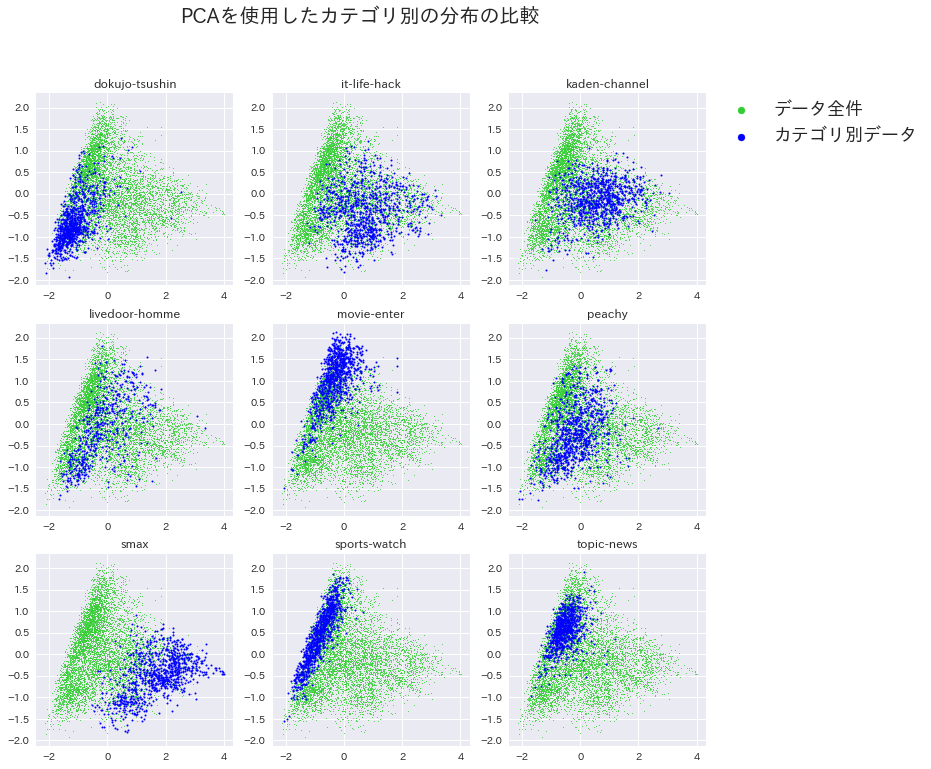

In [ ]:
vecs_pca = PCA(n_components=2, random_state=Cfg.seed).fit_transform(vecs)
scatter_plot(vecs_pca, labels, 'PCAを使用したカテゴリ別の分布の比較')

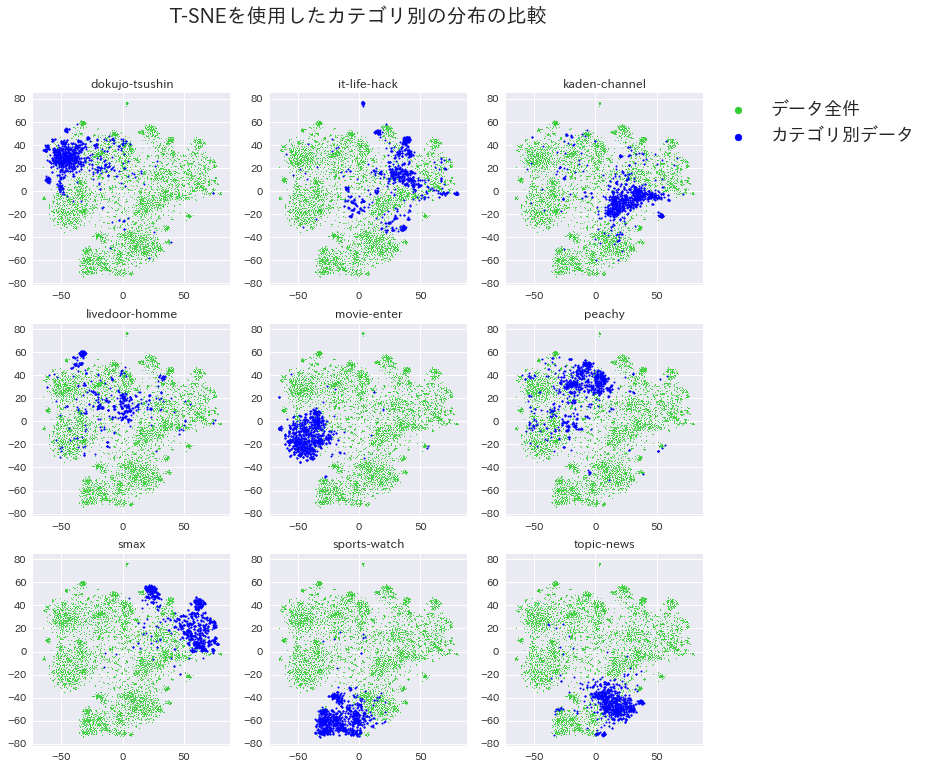

In [ ]:
vecs_tsne = TSNE(n_components=2, random_state=Cfg.seed).fit_transform(vecs)
scatter_plot(vecs_tsne, labels, 'T-SNEを使用したカテゴリ別の分布の比較')

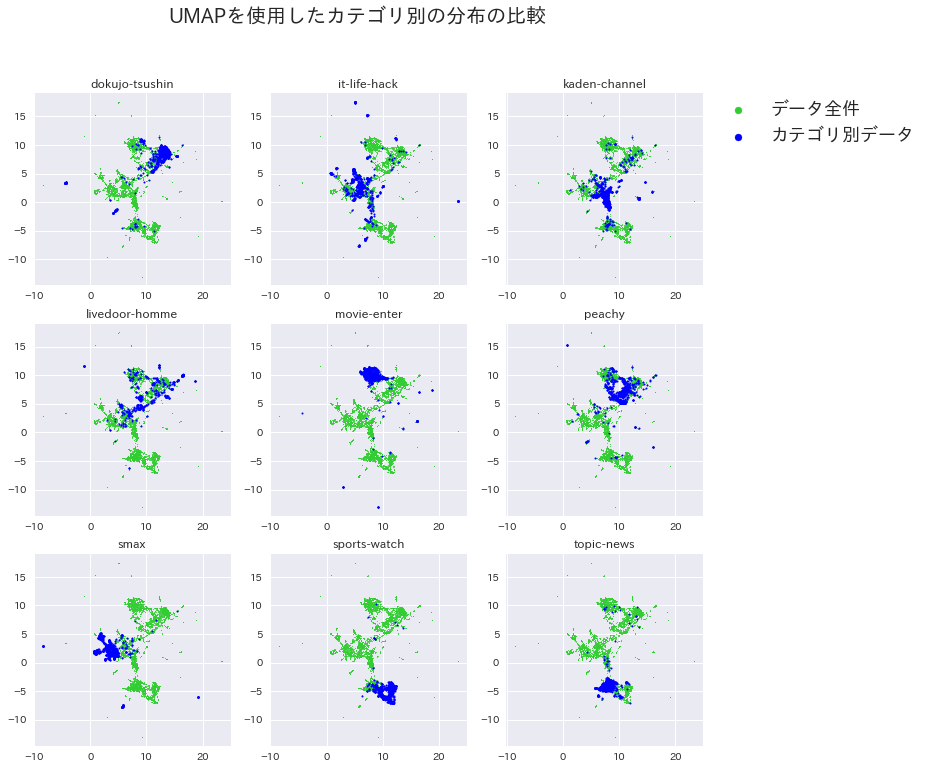

In [ ]:
vecs_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(vecs)
scatter_plot(vecs_umap, labels, 'UMAPを使用したカテゴリ別の分布の比較')

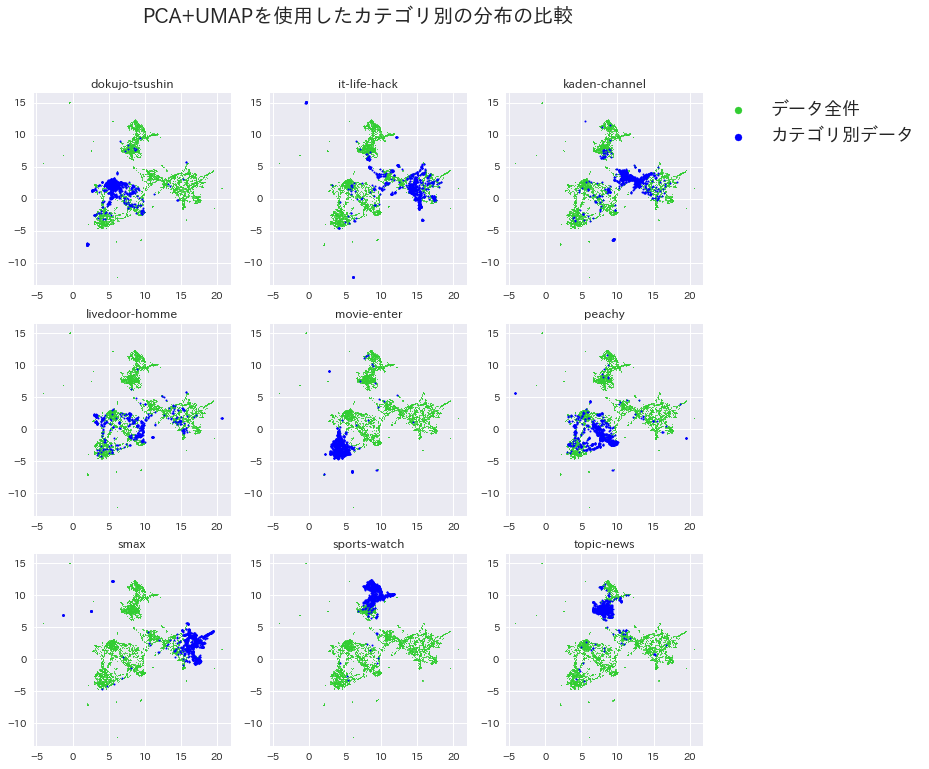

In [ ]:
# PCA + UMAP
vecs_pca_ = PCA(n_components=50, random_state=Cfg.seed).fit_transform(vecs)
vecs_pca_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(vecs_pca_)
scatter_plot(vecs_pca_umap, labels, 'PCA+UMAPを使用したカテゴリ別の分布の比較')

## Preprocess

In [12]:
data = data.drop(['url','datetime'], axis=1)

In [13]:
def body_text_slice(text):
    if '■' in text:
        pos = text.find('■')
        text = text[:pos]
    if '【関連' in text:
        pos = text.find('【関連')
        text = text[:pos]
    return text

def title_text_slice(text):
    if 'vol.' in text:
        pos = text.find('vol.')
        text = text[:pos]
    return text


def body_text_preprocess(text):
    text = mojimoji.han_to_zen(text, ascii=False, digit=False)
    text = mojimoji.zen_to_han(text, kana=False)
    text = body_text_slice(text)
    text = ''.join(text.split())
    # URL及び、記号類を取り除く(\n, \n>>)
    text = text.replace('>>', '')
    text = re.sub(r'(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+$,%#]+)', '' , text)
    text = text.strip()
    return text

def title_text_preprocess(text):
    text = mojimoji.han_to_zen(text, ascii=False, digit=False)
    text = mojimoji.zen_to_han(text, kana=False)
    # 【***】を取り除く
    text = re.sub('\【.+?\】', '', text)
    text = title_text_slice(text)
    text = ''.join(text.split())
    text = text.strip()
    return text


def apply_textPreprocess(df):
    new_df = df.copy()
    new_df.body = df.body.apply(lambda x: body_text_preprocess(x))
    new_df.title = df.title.apply(lambda x: title_text_preprocess(x))
    # 100文字以上のbodyを持つデータを抽出
    new_df = new_df[new_df.body.apply(lambda x: len(x)) > 100]
    # 1文字以上のtitleを持つデータを抽出
    new_df = new_df[new_df.title.apply(lambda x: len(x)) > 1]
    new_df = new_df.reset_index(drop=True)
    return new_df

In [14]:
preprocessed_data = apply_textPreprocess(data)

In [15]:
data.head(1)

,title,body,media
0,【Office Scope vol.02】目指したのは、とことんオープンな「ソーシャル」オフィス（株式会社ミクシィ）,ワークスペースのデザイニングに優れた企業のオフィスを訪問し、そこで働く人々の声から、その“働き心地”をリポートする連載企画『Office Scope』。第2回の今回は、言わずと知れた日本最大級のSNS『mixi』を運営する、株式会社ミクシィをフィーチャリング。現代社会の人間関係そのものにまで大きな変革をもたらしたITベンチャーが目指す「オフィスのオープン化」とは果たして！？\nおなじみのロゴが出迎えるエントランス。壁材にはあえて“味”のある錆びやすい素材をチョイス。\nデザインコンセプトは「素材感を活かす」こと。当然、床が傷つきやすい材質なのも計算のうちだ。\n眺望も素晴らしい来客用のスペースは、まるでどこかのオープンカフェのよう。\nオープン化した『mixi』同様、オフィスも開かれた空間に\n「今回の移転で弊社が目指したのは、08年から『mixi』で推進してきた“オープン化戦略”の流れを踏まえた“オフィスのオープン化”。サービスを外部から提供していただくことで、より幅広いニーズへの対応が可能にしてきた『mixi』と同様、オフィスそのものを、ソーシャルなコミュニケーションプラットフォームにしていきたい。そういったコンセプトのもとで新たにデザインされたのが、このオフィスというわけです」（ミクシィ・広報）\n04年のサービス開始からわずか7年で、日本国民の5人に1人に相当する2000万人超のユーザーを獲得。08年の“オープン化”以降でも、すでに2000を超えるアプリが『mixiアプリ』で運営され、法人・個人のパートナー数も3400以上を数えるなど、他を圧倒する速度で成長を続けてきたミクシィ社。今回われわれが訪れた彼らの新天地には、そんな業界のトップランナーの想いがつまった、まさに“オープン”な快適空間が広がっている。\n社内には来客用の25部屋を含む大小58室もの来客スペースが確保されている。\nミーティングスペースでは全室にプロジェクターを完備。事前登録でWi-Fiも使用可能に。\n扉は使えば使うほど錆びて“味”になる仕様。壁は一面がホワイトボードだ。\n一般の利用をも想定した充実のミーティングスペース\n「以前のオフィスでは、ぜんぶで22部屋しかなかったミーティングスペースは、来客用に25、社内用に33の合計42部屋と今回の移転でほぼ倍増。全室にホワイトボードとプロジェクターを常設してあるほか、セミナーや勉強会、記者会見など社外の方にもお使いいただけるよう、Ust配信なども想定してビデオカメラの貸し出しや、ゲストへのWi-Fiの開放も行えるようになっています」（前出・同）\n新オフィスは、自社で占有する3フロアのうち、1フロアすべてを来客専用スペースにするなど、本格的な“オープン化”のための大胆なレイアウト。これまでは社員の相互交流のみを目的に配置されていた“コラボレーションスペース”や新設されたラウンジさえもが、今回の移転に際しては、外部への開放を前提に全面リニューアルされたというから、その徹底ぶりにはもはや脱帽するほかない。\n社員たちの憩いの場であるコラボレーションスペース。奥の一角には畳敷きのエリアもある。\n社員同伴であれば第三者も利用可能なエリアであるため、この場所を外部の取引先や協力会社との「コミュニケーションプラットフォーム」にしていきたいとのこと。\nドリンクのバリエーションは社員の声を受けて大幅に改善。しかもすべて無料だ。\nビリヤードやダーツのあるラウンジにはアルコール類も常備。もちろん社員同伴なら外部の利用もOK。\n社員の声を活かして執務フロアでもさらなる快適性を追求\n「核となるコンセプトは経営陣が決定していますが、設備面では社員全員に実施したアンケートをもとに、その声はかなり反映されています。大きなものでは、エンジニアのためのクルーズ＆アトラスの導入などがそうですが、それ以外にも、以前から設置されていたコーヒーや紅茶が飲める無料のドリンクベンダーでポタージュなども選べるようにしたり、ゴミ箱の数を増やしたり、通路幅や空調の数を調整したりと、移転プロジェクトチームは細かなところでもけっこう苦心したみたいですよ（笑）」\nその甲斐あって、5フロアから3フロアに集約され、様々な改善が実施された現在のオフィスでは社内の交流も活性化。社員たちからも「社員が400人近くに増えたいまのほうが、全体の雰囲気がつかみやすい」とおおむね好評を得ているという。\n執務フロアの全景。奥のコンテナにはちょっとした休憩に便利な社員専用の“ミニコラボ”が。\nエンジニアの要望を受けて導入された“クルーズ＆アトラス”で作業効率もアップ。\n“ミニコラボ”に設置されたポストは、郵便物を投函すれば総務部が回収してくれるという優れもの。\n人と人との「つながり」から生まれる新しい価値観\n「あらゆるものに、人と人とのつながりを組み合わせることで、新しい価値が生みだしていく。今回の移転は弊社の描くSNSの未来像への第一歩。かつてはみんなで観るものだったテレビを、もう一度、友達と一緒に観ているかのような感覚にできる世界————そういった新たなソーシャル化の波を作っていきたいと思っています」\n若い世代にとっては日常生活とは切っても切れない、コミュニケーションツールのデフォルトとも言えるSNS。サービス・オフィスの両輪で“オープン化”を推進するミクシィ社の次なる展開に要注目である。\n■関連リンク\n・株式会社ミクシィ 公式サイト\n・SNS『mixi』トップページ\n・Office Scope過去記事一覧\nlivedoor求人・転職\nlivedoor求人・転職は、あなたがどんな求人情報を探しているのかを瞬時に判断しておすすめするコンテンツ。「東京都内で年収700万以上の営業職で未経験OK」などあなたのこだわりにマッチする転職活動を完全サポート。\nhttp://type.jp/s/livedoor/,livedoor-homme


In [16]:
preprocessed_data.head(1)

,title,body,media
0,目指したのは、とことんオープンな「ソーシャル」オフィス(株式会社ミクシィ),"ワークスペースのデザイニングに優れた企業のオフィスを訪問し、そこで働く人々の声から、その“働き心地""をリポートする連載企画『OfficeScope』。第2回の今回は、言わずと知れた日本最大級のSNS『mixi』を運営する、株式会社ミクシィをフィーチャリング。現代社会の人間関係そのものにまで大きな変革をもたらしたITベンチャーが目指す「オフィスのオープン化」とは果たして!?おなじみのロゴが出迎えるエントランス。壁材にはあえて“味""のある錆びやすい素材をチョイス。デザインコンセプトは「素材感を活かす」こと。当然、床が傷つきやすい材質なのも計算のうちだ。眺望も素晴らしい来客用のスペースは、まるでどこかのオープンカフェのよう。オープン化した『mixi』同様、オフィスも開かれた空間に「今回の移転で弊社が目指したのは、08年から『mixi』で推進してきた“オープン化戦略""の流れを踏まえた“オフィスのオープン化""。サービスを外部から提供していただくことで、より幅広いニーズへの対応が可能にしてきた『mixi』と同様、オフィスそのものを、ソーシャルなコミュニケーションプラットフォームにしていきたい。そういったコンセプトのもとで新たにデザインされたのが、このオフィスというわけです」(ミクシィ・広報)04年のサービス開始からわずか7年で、日本国民の5人に1人に相当する2000万人超のユーザーを獲得。08年の“オープン化""以降でも、すでに2000を超えるアプリが『mixiアプリ』で運営され、法人・個人のパートナー数も3400以上を数えるなど、他を圧倒する速度で成長を続けてきたミクシィ社。今回われわれが訪れた彼らの新天地には、そんな業界のトップランナーの想いがつまった、まさに“オープン""な快適空間が広がっている。社内には来客用の25部屋を含む大小58室もの来客スペースが確保されている。ミーティングスペースでは全室にプロジェクターを完備。事前登録でWi-Fiも使用可能に。扉は使えば使うほど錆びて“味""になる仕様。壁は一面がホワイトボードだ。一般の利用をも想定した充実のミーティングスペース「以前のオフィスでは、ぜんぶで22部屋しかなかったミーティングスペースは、来客用に25、社内用に33の合計42部屋と今回の移転でほぼ倍増。全室にホワイトボードとプロジェクターを常設してあるほか、セミナーや勉強会、記者会見など社外の方にもお使いいただけるよう、Ust配信なども想定してビデオカメラの貸し出しや、ゲストへのWi-Fiの開放も行えるようになっています」(前出・同)新オフィスは、自社で占有する3フロアのうち、1フロアすべてを来客専用スペースにするなど、本格的な“オープン化""のための大胆なレイアウト。これまでは社員の相互交流のみを目的に配置されていた“コラボレーションスペース""や新設されたラウンジさえもが、今回の移転に際しては、外部への開放を前提に全面リニューアルされたというから、その徹底ぶりにはもはや脱帽するほかない。社員たちの憩いの場であるコラボレーションスペース。奥の一角には畳敷きのエリアもある。社員同伴であれば第三者も利用可能なエリアであるため、この場所を外部の取引先や協力会社との「コミュニケーションプラットフォーム」にしていきたいとのこと。ドリンクのバリエーションは社員の声を受けて大幅に改善。しかもすべて無料だ。ビリヤードやダーツのあるラウンジにはアルコール類も常備。もちろん社員同伴なら外部の利用もOK。社員の声を活かして執務フロアでもさらなる快適性を追求「核となるコンセプトは経営陣が決定していますが、設備面では社員全員に実施したアンケートをもとに、その声はかなり反映されています。大きなものでは、エンジニアのためのクルーズ&アトラスの導入などがそうですが、それ以外にも、以前から設置されていたコーヒーや紅茶が飲める無料のドリンクベンダーでポタージュなども選べるようにしたり、ゴミ箱の数を増やしたり、通路幅や空調の数を調整したりと、移転プロジェクトチームは細かなところでもけっこう苦心したみたいですよ(笑)」その甲斐あって、5フロアから3フロアに集約され、様々な改善が実施された現在のオフィスでは社内の交流も活性化。社員たちからも「社員が400人近くに増えたいまのほうが、全体の雰囲気がつかみやすい」とおおむね好評を得ているという。執務フロアの全景。奥のコンテナにはちょっとした休憩に便利な社員専用の“ミニコラボ""が。エンジニアの要望を受けて導入された“クルーズ&アトラス""で作業効率もアップ。“ミニコラボ""に設置されたポストは、郵便物を投函すれば総務部が回収してくれるという優れもの。人と人との「つながり」から生まれる新しい価値観「あらゆるものに、人と人とのつながりを組み合わせることで、新しい価値が生みだしていく。今回の移転は弊社の描くSNSの未来像への第一歩。かつてはみんなで観るものだったテレビを、もう一度、友達と一緒に観ているかのような感覚にできる世界————そういった新たなソーシャル化の波を作っていきたいと思っています」若い世代にとっては日常生活とは切っても切れない、コミュニケーションツールのデフォルトとも言えるSNS。サービス・オフィスの両輪で“オープン化""を推進するミクシィ社の次なる展開に要注目である。",livedoor-homme


In [17]:
print(f'前処理前のtitleカラムの文字数統計量 \n {data.title.apply(lambda x: len(x)).describe()}\n')
print(f'前処理後のtitleカラムの文字数統計量 \n {preprocessed_data.title.apply(lambda x: len(x)).describe()}\n')
print(f'前処理前のbodyカラムの文字数統計量 \n {data.body.apply(lambda x: len(x)).describe()}\n')
print(f'前処理後のbodyカラムの文字数統計量 \n {preprocessed_data.body.apply(lambda x: len(x)).describe()}')

前処理前のtitleカラムの文字数統計量 
 count    7367.000000
mean       37.673001
std        14.800572
min         6.000000
25%        28.000000
50%        36.000000
75%        45.000000
max       142.000000
Name: title, dtype: float64

前処理後のtitleカラムの文字数統計量 
 count    7232.000000
mean       33.079923
std        13.577580
min         5.000000
25%        24.000000
50%        31.000000
75%        39.000000
max       131.000000
Name: title, dtype: float64

前処理前のbodyカラムの文字数統計量 
 count     7367.000000
mean      1205.801004
std        748.930301
min         11.000000
25%        687.000000
50%       1011.000000
75%       1552.000000
max      11826.000000
Name: body, dtype: float64

前処理後のbodyカラムの文字数統計量 
 count    7232.000000
mean      904.344718
std       641.194157
min       101.000000
25%       449.000000
50%       719.000000
75%      1224.250000
max      7878.000000
Name: body, dtype: float64


## Export

In [18]:
preprocessed_data.to_csv('../data/headlines_generation_corpus/preprocessed_livedoornews.csv', index=False)